In [142]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import (train_test_split,
                                     cross_val_score,
                                     StratifiedKFold,
                                     learning_curve, validation_curve,
                                     GridSearchCV, RandomizedSearchCV)
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import (confusion_matrix, accuracy_score,
                             roc_auc_score, roc_curve,
                             classification_report,
                             f1_score, make_scorer)
from sklearn.utils import resample

%matplotlib inline
sns.set_context("notebook")
plt.style.use("fivethirtyeight")

In [2]:
# Read the data
df = pd.read_csv('https://archive.ics.uci.edu/ml/'
                 'machine-learning-databases'
                 '/breast-cancer-wisconsin/wdbc.data',
                 header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [5]:
# Convert the dataframe into numpy objects: X, y
X = df.iloc[:, 2:].values
y = df.iloc[:, 1].values

# Encode the class labels
le = LabelEncoder()
y = le.fit_transform(y)
le.classes_, X.shape, y.shape

(array(['B', 'M'], dtype=object), (569, 30), (569,))

In [6]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=1, test_size=0.2, stratify=y)
X_train.shape, X_test.shape, np.bincount(y), np.bincount(y_train), np.bincount(y_test)

((455, 30), (114, 30), array([357, 212]), array([285, 170]), array([72, 42]))

In [58]:
# Create pipeline
pipeline_lr = make_pipeline(StandardScaler(),
                            PCA(n_components=2),
                            LogisticRegression(penalty="l2", random_state=1))
pipeline_lr.fit(X_train, y_train)
y_pred = pipeline_lr.predict(X_test)
print("The accuracy rate is: {:.2f}%".format(pipeline_lr.score(X_test, y_test) * 100))

The accuracy rate is: 95.61%


In [33]:
# Using Stratified CV
kfold = StratifiedKFold(n_splits=10, random_state=1).split(X_train, y_train)
scores = []
for k, (train, test) in enumerate(kfold):
    pipeline_lr.fit(X_train[train], y_train[train])
    scores.append(pipeline_lr.score(X_train[test], y_train[test]))
print("The 10-fold CV accuracy rate is {:.1f}% + {:.2f}% std".format(
    np.mean(scores) * 100, np.std(scores) * 100))

The 10-fold CV accuracy rate is 95.0% + 1.39% std


In [34]:
# Use scikit-learn CV
scores = cross_val_score(estimator=pipeline_lr, X=X_train, y=y_train, cv=10, n_jobs=1)
print("The 10-fold CV accuracy rate is {:.1f}% + {:.2f}% std".format(
    np.mean(scores) * 100, np.std(scores) * 100))

The 10-fold CV accuracy rate is 95.0% + 1.39% std


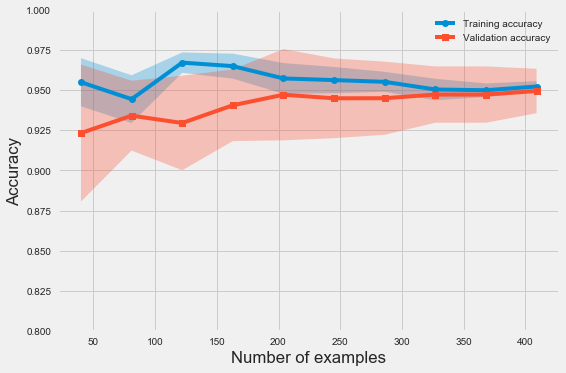

In [59]:
# Plot learning curve
train_sizes, train_scores, valid_scores = learning_curve(estimator=pipeline_lr,
                                                         X=X_train, y=y_train,
                                                         train_sizes=np.linspace(0.1, 1, 10),
                                                         cv=10, n_jobs=1)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
valid_mean = np.mean(valid_scores, axis=1)
valid_std = np.std(valid_scores, axis=1)

plt.plot(train_sizes, train_mean, marker="o",markersize=7, label="Training accuracy")
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.3)
plt.plot(train_sizes, valid_mean, marker="s",markersize=7, label="Validation accuracy")
plt.fill_between(train_sizes, valid_mean + valid_std, valid_mean - valid_std, alpha=0.3)
plt.ylim([0.8, 1])
plt.xlabel("Number of examples")
plt.ylabel("Accuracy")
plt.legend(loc="best")

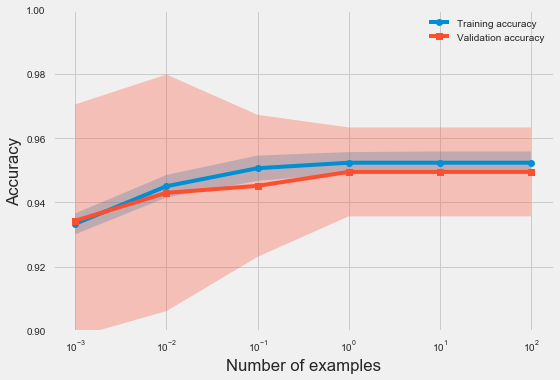

In [64]:
# Plot validation curve
#hyperparam_range = np.linspace(10 ** -4, 10 ** 4, 100)
hyperparam_range = [0.001, 0.01, 0.1, 1, 10, 100]
train_scores, valid_scores = validation_curve(estimator=pipeline_lr,
                                              X=X_train, y=y_train,
                                              param_name="logisticregression__C",
                                              param_range=hyperparam_range,
                                              cv=10, n_jobs=1)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
valid_mean = np.mean(valid_scores, axis=1)
valid_std = np.std(valid_scores, axis=1)

plt.plot(hyperparam_range, train_mean, marker="o",markersize=7, label="Training accuracy")
plt.fill_between(hyperparam_range, train_mean + train_std, train_mean - train_std, alpha=0.3)
plt.plot(hyperparam_range, valid_mean, marker="s",markersize=7, label="Validation accuracy")
plt.fill_between(hyperparam_range, valid_mean + valid_std, valid_mean - valid_std, alpha=0.3)
plt.ylim([0.9, 1])
plt.xscale("log")
plt.xlabel("Number of examples")
plt.ylabel("Accuracy")
plt.legend(loc="best")

In [72]:
# Use grid search with SVC
pipeline_svc = make_pipeline(StandardScaler(),
                             PCA(n_components=2),
                             SVC(random_state=1))
hyperparam_range = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]

param_grid = [{"svc__C": hyperparam_range, "svc__kernel": ["linear"]},
              {"svc__C": hyperparam_range, "svc__kernel": ["rbf"], "svc__gamma": hyperparam_range}]

gs = GridSearchCV(pipeline_svc, param_grid, cv=10, n_jobs=1, scoring="accuracy")
gs = gs.fit(X_train, y_train)
print(gs.best_params_, gs.best_score_)
gs.best_estimator_.fit(X_train, y_train)
print("The accuracy rate is: {:.2f}%".format(gs.best_estimator_.score(X_test, y_test) * 100))

{'svc__C': 1, 'svc__kernel': 'linear'} 0.951648351648
The accuracy rate is: 96.49%


In [73]:
# Using nested CV
gs = GridSearchCV(pipeline_svc, param_grid, cv=2, n_jobs=1, scoring="accuracy")
scores = cross_val_score(gs, X=X_train, y=y_train, scoring="accuracy", cv=5)
np.mean(scores)

0.93846153846153846

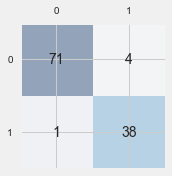

In [83]:
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(conf_mat, cmap=plt.cm.Blues, alpha=0.4)
for i in range(conf_mat.shape[0]):
    for j in range(conf_mat.shape[1]):
        ax.text(x=i, y=j, s=conf_mat[i, j], va="center", ha="center")

In [85]:
f1_score(y_test, y_pred)

0.93827160493827155

In [109]:
X[y == 1].shape, X[y == 0].shape 

((212, 30), (357, 30))

In [110]:
X_upsampled, y_upsampled = resample(
    X[y == 1], y[y == 1], replace=True, n_samples=X[y == 0].shape[0], random_state=1)

In [112]:
X_upsampled.shape, y_upsampled.shape

((357, 30), (357,))

In [113]:
# Create pipeline
pipeline_lr = make_pipeline(StandardScaler(),
                            LogisticRegression(penalty="l2", random_state=1))
pipeline_lr.fit(X_train, y_train)
y_pred = pipeline_lr.predict(X_test)
print("The accuracy rate is: {:.2f}%".format(pipeline_lr.score(X_test, y_test) * 100))

The accuracy rate is: 98.25%


In [128]:
hyperparam_range = [0.02 * 2 ** i for i in range(20)]
param_grid = [{"logisticregression__C": hyperparam_range}]
gc = GridSearchCV(pipeline_lr, param_grid, scoring="f1", cv=10, n_jobs=1)
gc.fit(X_train, y_train)
gc.best_score_

0.97603729603729605

In [129]:
accuracy_score(y_test, gc.best_estimator_.predict(X_test))

0.98245614035087714

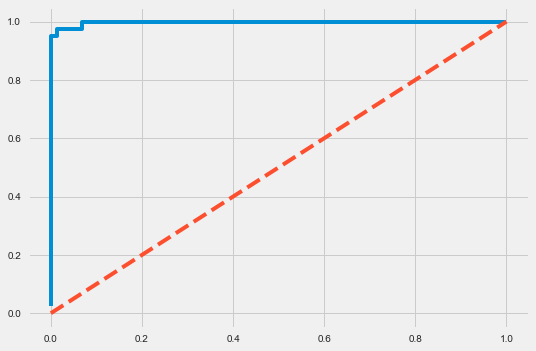

In [138]:
fpr, tpr, thresholds = roc_curve(y_test, gc.best_estimator_.predict_proba(X_test)[:, 1])
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], "--")

In [141]:
print(classification_report(y_test, gc.best_estimator_.predict(X_test)))

             precision    recall  f1-score   support

          0       0.99      0.99      0.99        72
          1       0.98      0.98      0.98        42

avg / total       0.98      0.98      0.98       114



In [ ]:
make_pipeline()